# Prueba de conceptos

En este vamos a hacer una pruenba con 2 imagenes (Una por delante y la otra por detras), para demostrar los conceptos que usaremos en la implementacion.

## vamos a importar las imagenes

In [ ]:
!pip install tqdm

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tqdm

(np.float64(-0.5), np.float64(3595.5), np.float64(2539.5), np.float64(-0.5))

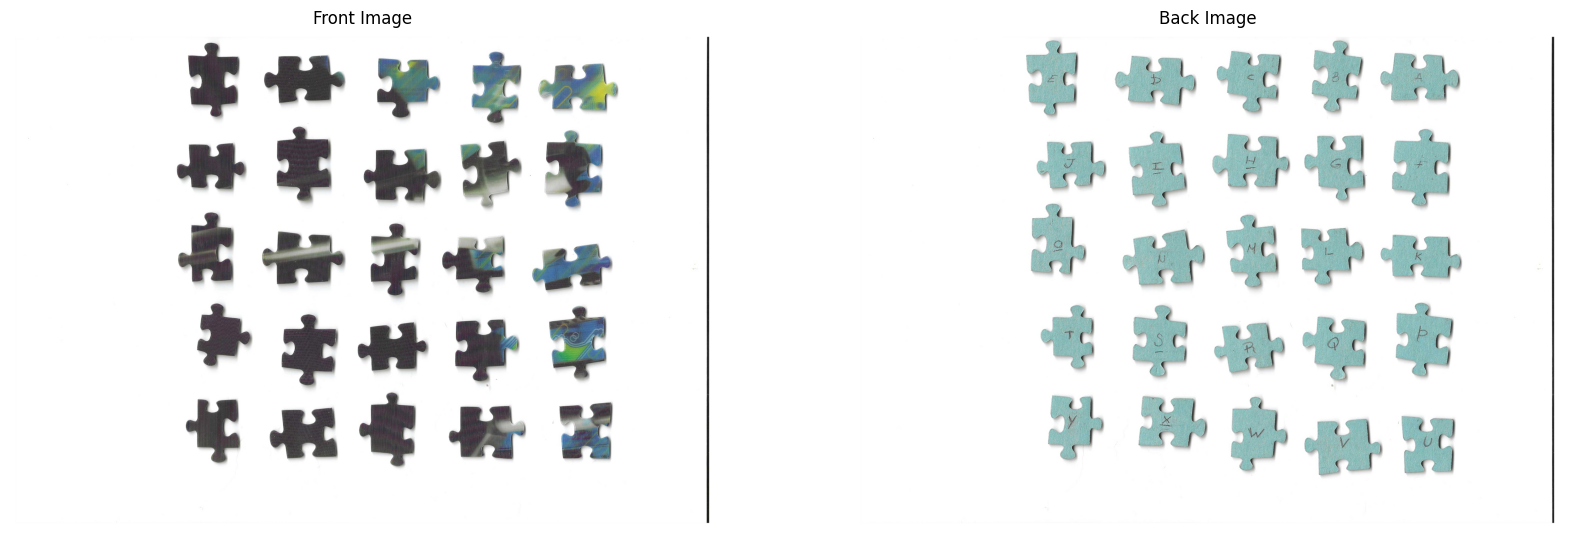

In [463]:
path = 'fotos/scan_25/'

front = cv.imread(path + 'front.jpg')
front = cv.rotate( front, cv.ROTATE_90_CLOCKWISE )
front = cv.copyMakeBorder(front, 30, 30, 30, 30, cv.BORDER_CONSTANT, value=[255, 255, 255])

back = cv.imread(path + 'back.jpg')
back = cv.rotate( back, cv.ROTATE_90_CLOCKWISE )
back = cv.copyMakeBorder(back, 30, 30, 30, 30, cv.BORDER_CONSTANT, value=[255, 255, 255])

front_gray = cv.cvtColor(front, cv.COLOR_BGR2GRAY)
back_gray = cv.cvtColor(back, cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(cv.cvtColor(front, cv.COLOR_BGR2RGB))
axes[0].set_title('Front Image')
axes[0].axis('off')
axes[1].imshow(cv.cvtColor(back, cv.COLOR_BGR2RGB))
axes[1].set_title('Back Image')
axes[1].axis('off')

## Segmentacion de las piezas

Como el fondo es banco uniforme, podemos usar un thresshold binario para segmentar las piezas del fondo, lo haremos con las piezas delanteras y traseras por separado.

(np.float64(-0.5), np.float64(3595.5), np.float64(2539.5), np.float64(-0.5))

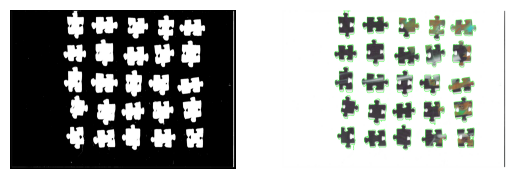

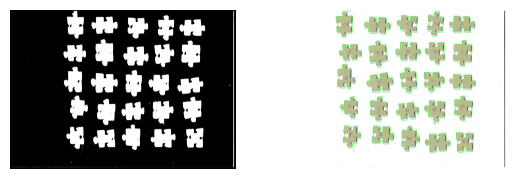

In [464]:
front_thresh = cv.threshold(front_gray, 250, 255, cv.THRESH_BINARY_INV)[1]
back_thresh = cv.threshold(back_gray, 250, 255, cv.THRESH_BINARY_INV)[1]

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.imshow(front_thresh, cmap='gray')
plt.axis('off')

front_contours , _ = cv.findContours(front_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
front_contours = sorted(front_contours, key=cv.contourArea, reverse=True)[:25]
front_segmented = front.copy()
contornos_in_original = cv.drawContours(front_segmented, front_contours, -1, (0, 255, 0), 3)

plt.sca(ax[1])
plt.imshow(contornos_in_original)
plt.axis('off')

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.imshow(front_thresh, cmap='gray')
plt.axis('off')

back_contours , _ = cv.findContours(back_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
back_contours = sorted(back_contours, key=cv.contourArea, reverse=True)[:25]
back_segmented = back.copy()
contornos_in_original = cv.drawContours(back_segmented, back_contours, -1, (0, 255, 0), 3)

plt.sca(ax[1])
plt.imshow(contornos_in_original)
plt.axis('off')

Como queremos guardar una asociacion entre piezas deleanteras y traseras vamos a reordenar las piezas segun su posicion asumineto que en las fotos estan formando una cuadricula 5 x 5.

In [465]:
def sort_contours(contours, imagen, ax = None):

    if ax != None:
        plt.sca(ax)
        plt.grid("off")

    ordered_contours = []


    centroids = np.array([np.mean(c.reshape(-1, 2), axis=0) for c in contours])
    x_centroids = centroids[:, 0]
    y_centroids = centroids[:, 1]

    # Hacemos un clustering para agrupar las coordenadas en 5 grupos
    x_prediction = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit(x_centroids.reshape(-1, 1))
    y_prediction = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit(y_centroids.reshape(-1, 1))

    # ploteamos la regilla generada para comprobar que es correcta
    plt.imshow(imagen)
    

    for i in range(5):
        plt.axvline(x=np.mean(x_centroids[x_prediction.labels_ == i]), color='black', linestyle='--')
        plt.axhline(y=np.mean(y_centroids[y_prediction.labels_ == i]), color='black', linestyle='--')

    plt.scatter(x_centroids, y_centroids, c=y_prediction.labels_ * 5, cmap='tab20')

    plt.title('Clustering de centroides')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid()

    cluster_centers_x = sorted(list(enumerate(x_prediction.cluster_centers_.flatten())), key=lambda x: x[1])
    cluster_centers_y = sorted(list(enumerate(y_prediction.cluster_centers_.flatten())), key=lambda x: x[1])

    for i, y_center in cluster_centers_y:
        for j, x_center in cluster_centers_x:
            index = np.where((y_prediction.labels_ == i) & (x_prediction.labels_ == j))[0][0]
            centroid = centroids[index]
            ordered_contours.append(contours[index])
            plt.text(centroid[0], centroid[1], f'{len(ordered_contours)}', color='red', fontsize=12)
    
    return ordered_contours

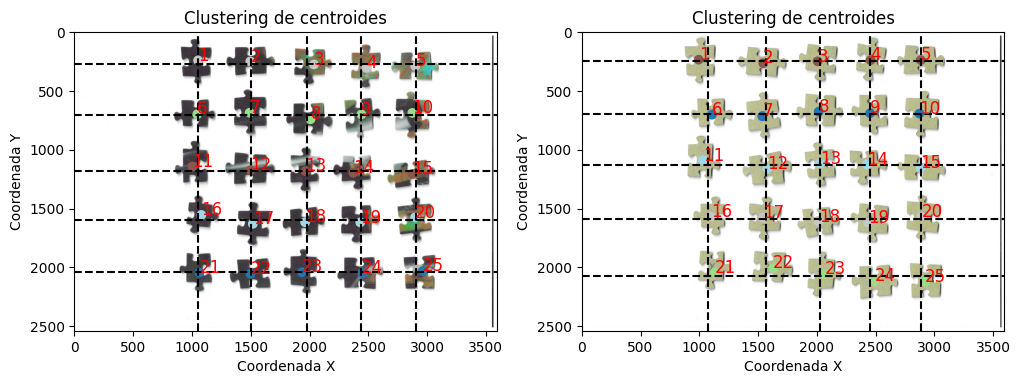

In [466]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

front_contours = sort_contours(front_contours, front, ax=axes[0])
back_contours = sort_contours(back_contours, back, ax=axes[1])

comprobamos que ahora el orden nos crea una asociacion correcta entre piezas delanteras y traseras.

A continuacino generamos los ROIS

In [467]:
front_rois = []

for contorno in front_contours:

    center = np.mean(contorno, axis=0).astype(int)
    max_x = np.max(contorno[:, 0, 0])
    min_x = np.min(contorno[:, 0, 0])
    max_y = np.max(contorno[:, 0, 1])
    min_y = np.min(contorno[:, 0, 1])

    pad = 20

    roi_front = front[min_y - pad:max_y + pad, min_x - pad:max_x + pad]
    front_rois.append(roi_front)

back_rois = []

for contorno in back_contours:

    center = np.mean(contorno, axis=0).astype(int)
    max_x = np.max(contorno[:, 0, 0])
    min_x = np.min(contorno[:, 0, 0])
    max_y = np.max(contorno[:, 0, 1])
    min_y = np.min(contorno[:, 0, 1])

    pad = 20

    roi_back = back[min_y - pad:max_y + pad, min_x - pad:max_x + pad]
    back_rois.append(roi_back)

Comprobamos que los ROIS son correctos

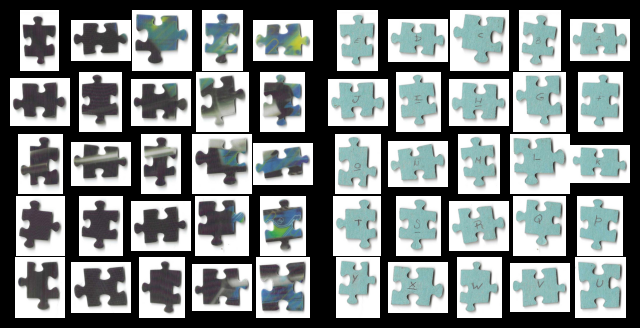

In [468]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(8, 4), facecolor='black')

outer_gs = gridspec.GridSpec(1, 2, wspace=0.05)

left_gs = gridspec.GridSpecFromSubplotSpec(
    5, 5, subplot_spec=outer_gs[0], wspace=0.02, hspace=0.02
)

for i in range(25):
    ax = fig.add_subplot(left_gs[i])
    ax.imshow(cv.cvtColor(front_rois[i], cv.COLOR_BGR2RGB))
    ax.axis('off')


right_gs = gridspec.GridSpecFromSubplotSpec(
    5, 5, subplot_spec=outer_gs[1], wspace=0.02, hspace=0.02
)

for i in range(25):
    ax = fig.add_subplot(right_gs[i])
    ax.imshow(cv.cvtColor(back_rois[i], cv.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

Una vez comprobado que los rois son correctos vamos a guardarlos enumerados en una carpeta.

In [469]:
for i, roi in enumerate(front_rois):
    cv.imwrite(f'fotos/segmented_scan_25/front/{i:02d}.png', roi)

for i, roi in enumerate(back_rois):
    cv.imwrite(f'fotos/segmented_scan_25/back/{i:02d}.png', roi)

# Deteccion de aristas y esquinas

vamos a tomar una sola pieza (vista desde atras) para hacer la deteccion de aristas y esquinas.

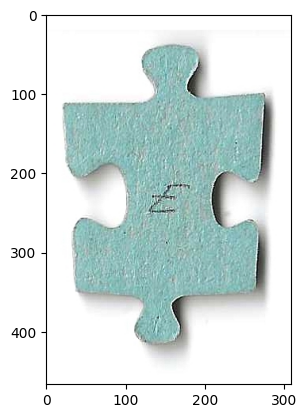

In [470]:
sample_piece = back_rois[0]
sample_piece_gray = cv.cvtColor(sample_piece, cv.COLOR_BGR2GRAY)

plt.imshow(cv.cvtColor(sample_piece, cv.COLOR_BGR2RGB))

## Grab Cut para segmentacion precisa

### Ajuste del margen.

haremos el rectangulo inicial con un thresholding muy basico ajustado pero asegurandolos de no cortar la pieza.

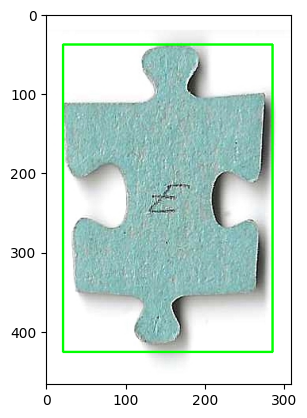

In [476]:
mask = cv.threshold(sample_piece_gray, 200, 255, cv.THRESH_BINARY_INV)[1]

minx = np.min(np.where(mask == 255)[1])
maxx = np.max(np.where(mask == 255)[1])
miny = np.min(np.where(mask == 255)[0])
maxy = np.max(np.where(mask == 255)[0])

rect = (minx, miny, maxx - minx, maxy - miny)

img = sample_piece.copy()
cv.rectangle(img, (minx, miny), (maxx, maxy), (0, 255, 0), 2)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### matriz de planos.

mask

cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.

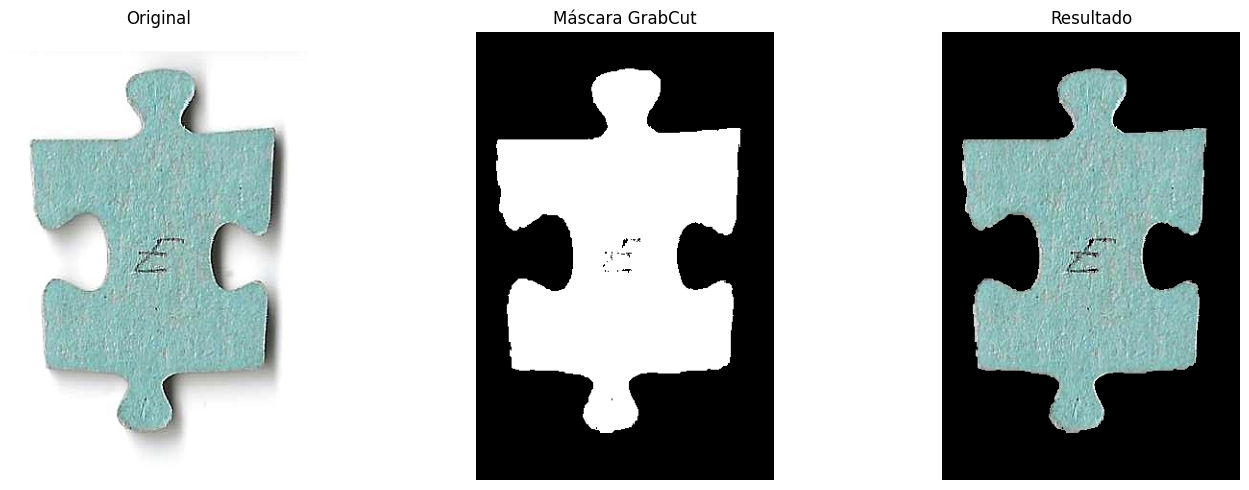

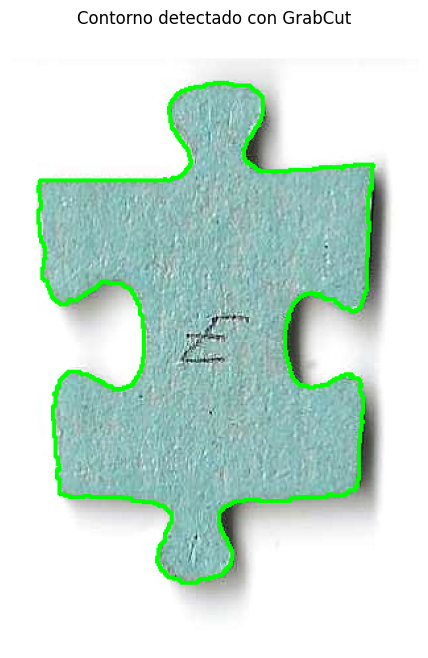

In [477]:
mask_gc = np.zeros(sample_piece.shape[:2], np.uint8)

# Definir rectángulo inicial (dejando margen del borde)
#margin = 25
#rect = (margin, margin, sample_piece.shape[1] - 2*margin, sample_piece.shape[0] - 2*margin)

# Modelos temporales para GrabCut
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Ejecutar GrabCut con rectángulo inicial
cv.grabCut(sample_piece,
           mask_gc,
           rect,
           bgd_model,
           fgd_model,
           50,
           cv.GC_INIT_WITH_RECT)

# Crear máscara binaria (0,2 = fondo, 1,3 = primer plano)
mask_result = np.where((mask_gc == 2) | (mask_gc == 0), 0, 1).astype('uint8')

# Aplicar máscara a la imagen
result = sample_piece * mask_result[:, :, np.newaxis]

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv.cvtColor(sample_piece, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(mask_result, cmap='gray')
axes[1].set_title('Máscara GrabCut')
axes[1].axis('off')

axes[2].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
axes[2].set_title('Resultado')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Obtener contorno de la máscara
contours_gc, _ = cv.findContours(mask_result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
best_contour_gc = max(contours_gc, key=cv.contourArea)

# Dibujar contorno
img_contour = sample_piece.copy()
cv.drawContours(img_contour, [best_contour_gc], 0, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(img_contour, cv.COLOR_BGR2RGB))
plt.title('Contorno detectado con GrabCut')
plt.axis('off')
plt.show()

In [ ]:
def apply_grabcut(image):
    def get_rect():
        mask = cv.threshold(cv.cvtColor(image, cv.COLOR_BGR2GRAY), 200, 255, cv.THRESH_BINARY_INV)[1]
        minx = np.min(np.where(mask == 255)[1])
        maxx = np.max(np.where(mask == 255)[1])
        miny = np.min(np.where(mask == 255)[0])
        maxy = np.max(np.where(mask == 255)[0])
        margin = 5
        return (minx - margin, miny - margin, maxx - minx + 2 * margin, maxy - miny + 2 * margin)

    rect = get_rect()

    mask_gc = np.zeros(image.shape[:2], np.uint8)

    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Subir a 50?

    cv.grabCut(image,
               mask_gc,
               rect,
               bgd_model,
               fgd_model,
               30,
                cv.GC_INIT_WITH_RECT)

    mask_result = np.where((mask_gc == 2) | (mask_gc == 0), 0, 1).astype('uint8')
    contours = cv.findContours(mask_result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    best_contour = max(contours, key=cv.contourArea)

    return best_contour

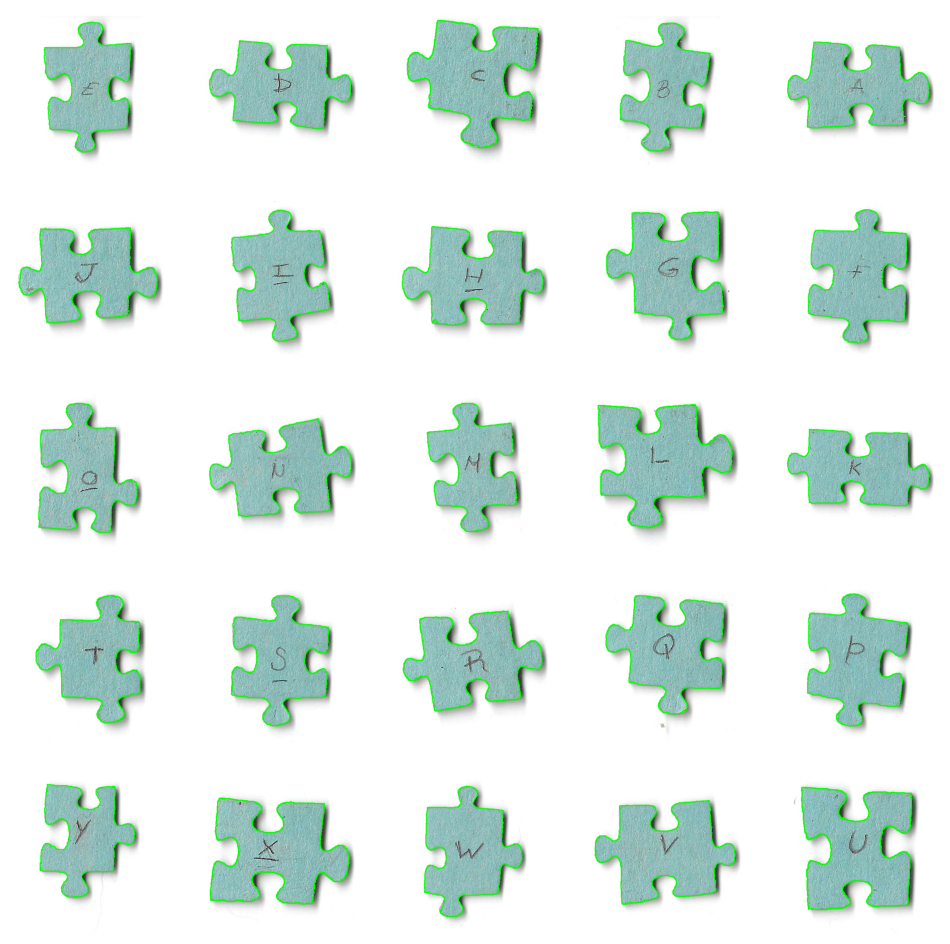

In [491]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()

masks = []
contours = []

for i in range(25):
    contour = apply_grabcut(back_rois[i])
    img_contour = back_rois[i].copy()
    cv.drawContours(img_contour, [contour], 0, (0, 255, 0), 2)
    axs[i].imshow(cv.cvtColor(img_contour, cv.COLOR_BGR2RGB))
    axs[i].axis('off')

    mask = cv.drawContours(np.zeros(back_rois[i].shape[:2], dtype=np.uint8), [contour], -1, 255, thickness=-1)

    masks.append(mask)
    contours.append(contour)


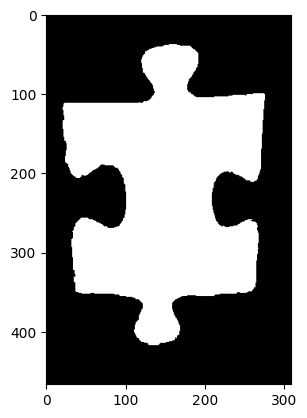

In [498]:
plt.imshow(masks[0], cmap='gray')

In [499]:
for i, mask in enumerate(masks):
    #guardar imagenes
    cv.imwrite(f'fotos/segmented_scan_25/back_contours/{i:02d}.png', mask)

# Pruebas thressholding

In [473]:
# thressholding

cv.threshold(blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
plt.imshow(combined_mask, cmap='gray')

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/thresh.cpp:1633: error: (-2:Unspecified error) in function 'double cv::threshold(cv::InputArray, cv::OutputArray, double, double, int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 16 (CV_8UC3)


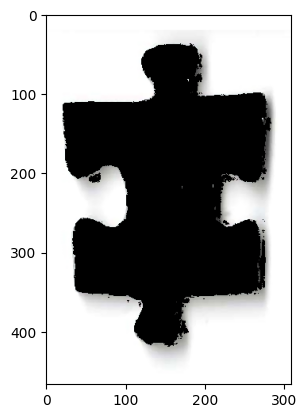

In [ ]:
blurred_hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

# enmascaramos los valores ocn saturacion muy bajos para ver si son la sombre

mask_shadow = cv.inRange(blurred_hsv, (0, 0, 0), (179, 10, 255))

if mask_shadow[0,0] == 0:
    mask_shadow = cv.bitwise_not(mask_shadow)

plt.imshow(cv.cvtColor(cv.bitwise_and(blurred, blurred, mask=mask_shadow), cv.COLOR_BGR2RGB), cmap='gray')


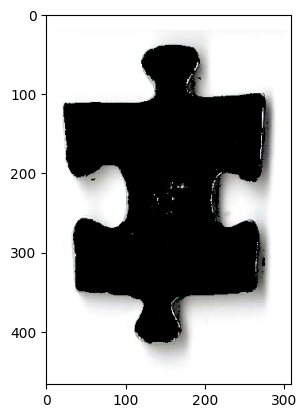

In [ ]:
blurred_hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

lower_cyan = np.array([30, 20, 50])
upper_cyan = np.array([150, 255, 255])

mask_shadow = cv.inRange(blurred_hsv, lower_cyan, upper_cyan)

if mask_shadow[0,0] == 0:
    mask_shadow = cv.bitwise_not(mask_shadow)

plt.imshow(cv.cvtColor(cv.bitwise_and(blurred, blurred, mask=mask_shadow), cv.COLOR_BGR2RGB), cmap='gray')

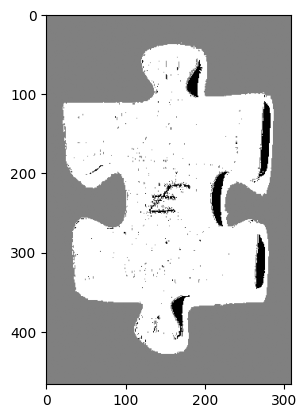

In [478]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
blurred_reshaped = blurred.reshape((-1, 3)).astype(np.float32)
_, labels, centers = cv.kmeans(blurred_reshaped, 3, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

mask = labels.reshape(blurred.shape[:2])

if mask[0,0] == 0:
    mask = cv.bitwise_not(mask)

plt.imshow(mask, cmap='gray')

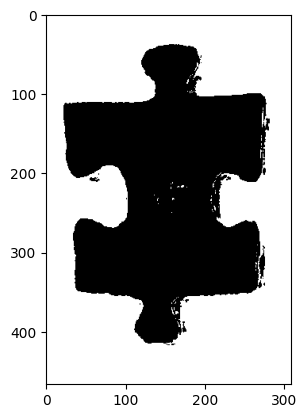

In [ ]:
combined_mask = cv.bitwise_or(mask.astype(np.uint8), mask_shadow)
plt.imshow(combined_mask, cmap='gray')

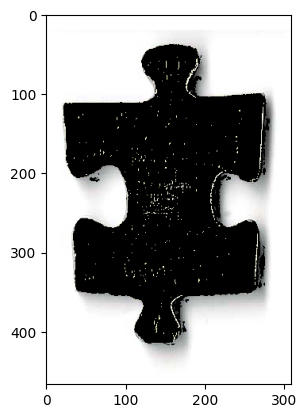

In [ ]:
plt.imshow(cv.bitwise_and(blurred, blurred, mask=combined_mask), cmap='gray')

## CANNY

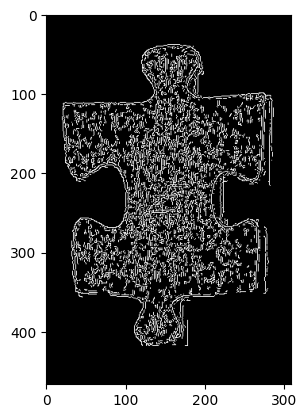

In [ ]:
edges = cv.Canny(blurred, 100, 150)
plt.imshow(edges, cmap='gray')